Using device: cuda


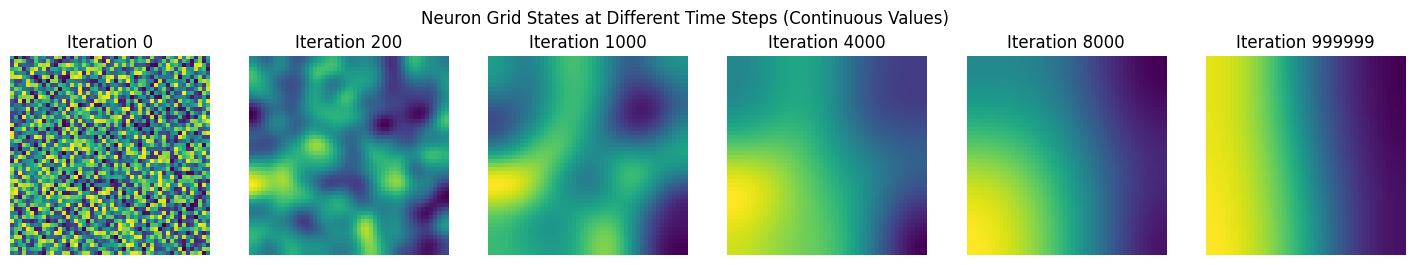

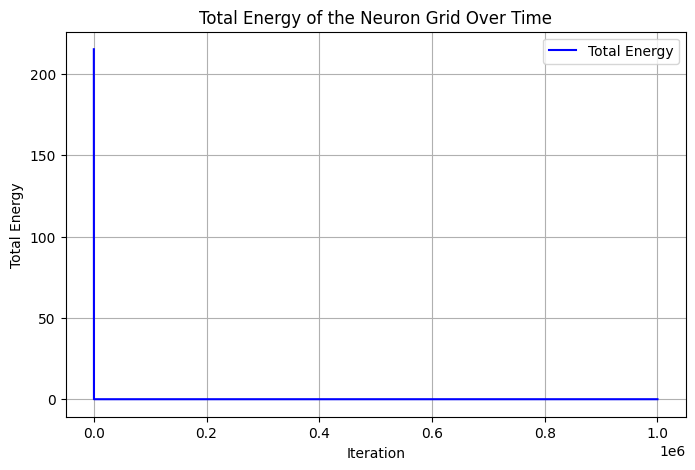

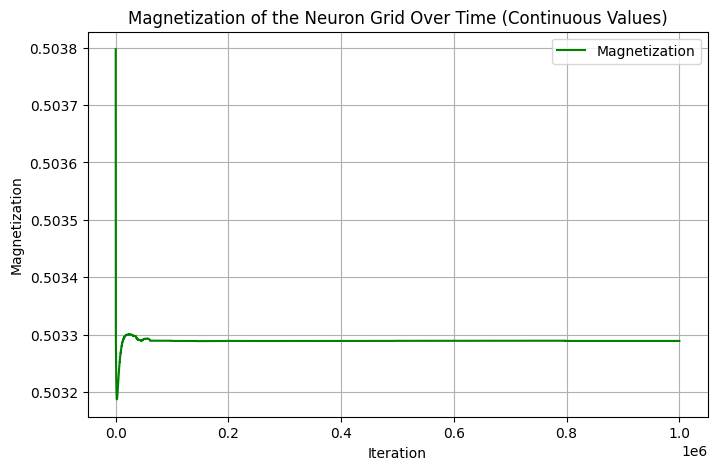

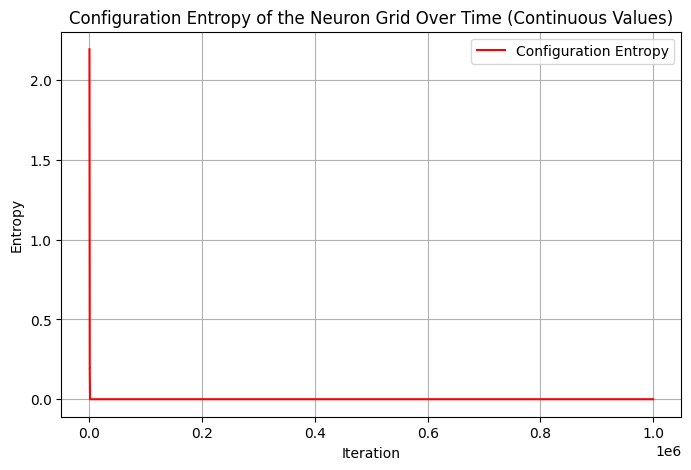

Heat Capacity: 1.0719857521292426


In [21]:
#CONTINUOS BOLTZMAN

import numpy as np
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Grid size and parameters
grid_size = 50
num_iterations = 1000000
initial_temperature = 5.0
final_temperature = 0.5
learning_rate = 0.1

# Initialize a grid of neurons with random continuous values between 0 and 1
neuron_grid = torch.rand((grid_size, grid_size), device=device)

# Define a function to compute the local energy of a neuron
def local_energy(neuron, neighbors):
    # Using a continuous energy function: encouraging alignment with neighbors
    return torch.sum((neuron - neighbors)**2)

# Define the update rule for all neurons in parallel with temperature
def update_neurons(grid, temperature=1.0, learning_rate=0.1):
    # Get the average of each neuron's neighbors
    kernel = torch.tensor([[1.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, 1.0]], device=device)
    neighbors_sum = torch.nn.functional.conv2d(grid.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1).squeeze(0).squeeze(0)
    neighbor_count = torch.nn.functional.conv2d(torch.ones_like(grid).unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1).squeeze(0).squeeze(0)

    # Calculate the average neighbor value
    neighbors_avg = neighbors_sum / neighbor_count
    
    # Calculate the gradient and update the grid
    gradient = 2 * (grid - neighbors_avg)
    grid -= learning_rate * gradient / temperature
    
    # Ensure the neuron state remains within [0, 1]
    grid.clamp_(0, 1)

# Function to calculate total energy of the grid
def total_energy(grid):
    kernel = torch.tensor([[1.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, 1.0]], device=device)
    neighbors_sum = torch.nn.functional.conv2d(grid.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1).squeeze(0).squeeze(0)
    neighbor_count = torch.nn.functional.conv2d(torch.ones_like(grid).unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1).squeeze(0).squeeze(0)
    neighbors_avg = neighbors_sum / neighbor_count
    energy = torch.sum((grid - neighbors_avg) ** 2)
    return energy.item()

# Function to calculate magnetization of the grid (mean value of the grid)
def magnetization(grid):
    return torch.mean(grid).item()

# Function to calculate heat capacity
def heat_capacity(energies, temperature):
    avg_energy = np.mean(energies)
    avg_energy_sq = np.mean(np.square(energies))
    return (avg_energy_sq - avg_energy ** 2) / (temperature ** 2)

# Function to calculate spin configuration entropy
def configuration_entropy(grid):
    # Bin continuous values into discrete categories to estimate entropy
    grid_np = grid.cpu().numpy()
    binned_grid = np.digitize(grid_np, bins=np.linspace(0, 1, 10))
    unique, counts = np.unique(binned_grid, return_counts=True)
    probabilities = counts / float(np.sum(counts))
    return -np.sum(probabilities * np.log(probabilities))

# Parameters for plotting
plot_times = [0, 200, 1000, 4000, 8000, 999999]  # Iterations at which to plot the grid
energy_history = []
magnetization_history = []
entropy_history = []

# Prepare for plotting
fig, axes = plt.subplots(1, 6, figsize=(18, 3))

# Run the simulation
for t in range(num_iterations):
    # Adjust temperature over time (simulated annealing)
    temperature = initial_temperature * ((final_temperature / initial_temperature) ** (t / num_iterations))
    
    # Perform a single iteration of gradient-based updates for all neurons
    update_neurons(neuron_grid, temperature=temperature, learning_rate=learning_rate)
    
    # Calculate and store the total energy of the grid
    energy = total_energy(neuron_grid)
    energy_history.append(energy)
    
    # Calculate and store the magnetization of the grid
    mag = magnetization(neuron_grid)
    magnetization_history.append(mag)
    
    # Calculate and store the configuration entropy of the grid
    entropy = configuration_entropy(neuron_grid)
    entropy_history.append(entropy)
    
    # Plot the grid at specified time steps
    if t in plot_times:
        idx = plot_times.index(t)
        axes[idx].imshow(neuron_grid.cpu(), cmap='viridis', interpolation='nearest')
        axes[idx].set_title(f"Iteration {t}")
        axes[idx].axis('off')

# Display the grid plots
plt.suptitle("Neuron Grid States at Different Time Steps (Continuous Values)")
plt.show()

# Plot energy over time
plt.figure(figsize=(8, 5))
plt.plot(energy_history, label="Total Energy", color='b')
plt.xlabel("Iteration")
plt.ylabel("Total Energy")
plt.title("Total Energy of the Neuron Grid Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot magnetization over time
plt.figure(figsize=(8, 5))
plt.plot(magnetization_history, label="Magnetization", color='g')
plt.xlabel("Iteration")
plt.ylabel("Magnetization")
plt.title("Magnetization of the Neuron Grid Over Time (Continuous Values)")
plt.grid(True)
plt.legend()
plt.show()

# Plot configuration entropy over time
plt.figure(figsize=(8, 5))
plt.plot(entropy_history, label="Configuration Entropy", color='r')
plt.xlabel("Iteration")
plt.ylabel("Entropy")
plt.title("Configuration Entropy of the Neuron Grid Over Time (Continuous Values)")
plt.grid(True)
plt.legend()
plt.show()

# Calculate and plot heat capacity
heat_cap = heat_capacity(energy_history, temperature)
print(f"Heat Capacity: {heat_cap}")


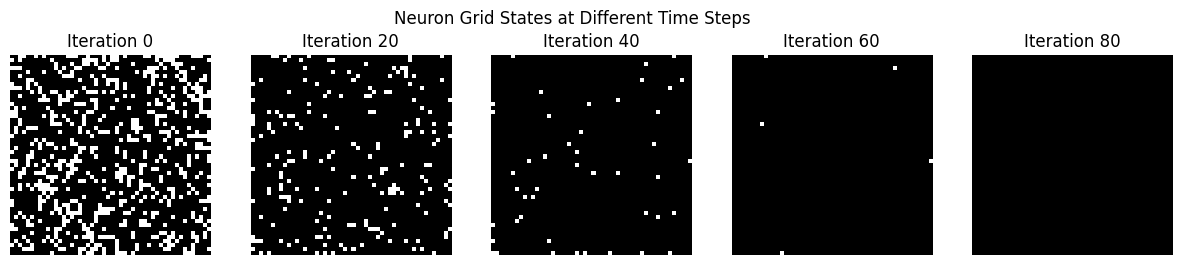

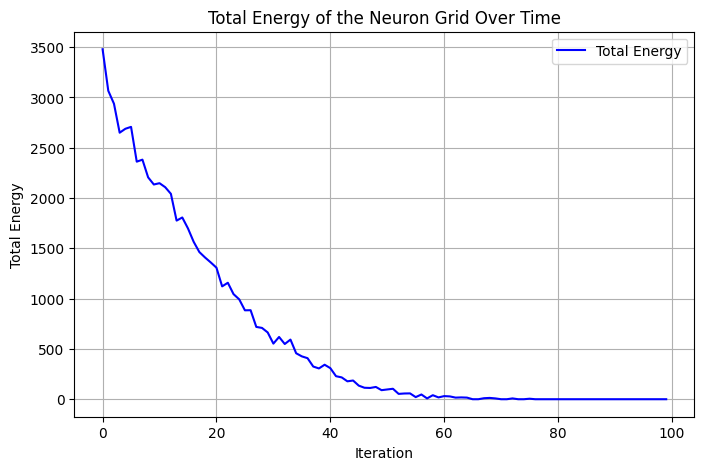

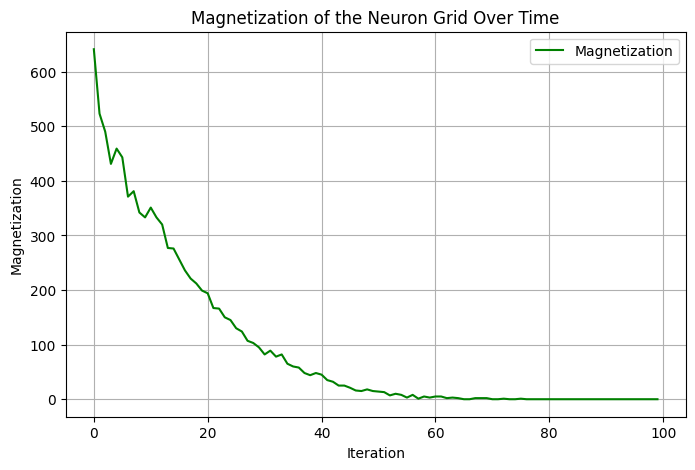

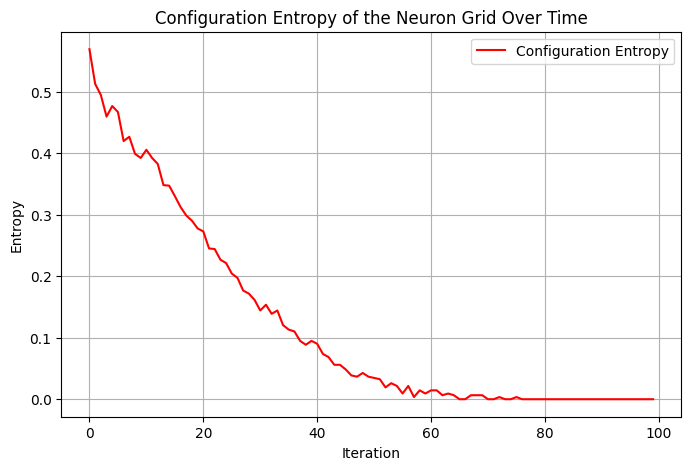

Heat Capacity: 3012897.6487867134


In [13]:
#DISCRETE BOLTZMAN

import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Grid size
grid_size = 50

# Initialize a grid of neurons with random states (0 or 1)
neuron_grid = np.random.randint(0, 2, (grid_size, grid_size))

# Define a function to compute the local energy of a neuron
def local_energy(neuron, neighbors):
    # Using the Ising model style energy function: aligning with neighbors reduces energy
    return -np.sum(neuron * (neighbors - neuron))

# Define the update rule for a single neuron with temperature
def update_neuron(grid, i, j, temperature=1.0):
    # Get the state of the current neuron
    neuron = grid[i, j]
    # Get the states of neighboring neurons (exclude edges by max/min)
    neighbors = grid[max(0, i-1):min(grid_size, i+2), max(0, j-1):min(grid_size, j+2)]
    # Calculate the local energy for both possible states (0 and 1)
    energy_0 = local_energy(0, neighbors)
    energy_1 = local_energy(1, neighbors)
    # Probability of switching to state 1 with temperature adjustment
    prob_1 = np.exp(-energy_1 / temperature) / (np.exp(-energy_0 / temperature) + np.exp(-energy_1 / temperature))
    # Update the neuron state based on this probability
    grid[i, j] = 1 if np.random.rand() < prob_1 else 0

# Function to calculate total energy of the grid
def total_energy(grid):
    total = 0
    for i in range(grid_size):
        for j in range(grid_size):
            neighbors = grid[max(0, i-1):min(grid_size, i+2), max(0, j-1):min(grid_size, j+2)]
            total += local_energy(grid[i, j], neighbors)
    return total

# Function to calculate magnetization of the grid
def magnetization(grid):
    return np.sum(grid)

# Function to calculate heat capacity
def heat_capacity(energies, temperature):
    avg_energy = np.mean(energies)
    avg_energy_sq = np.mean(np.square(energies))
    return (avg_energy_sq - avg_energy ** 2) / (temperature ** 2)

# Function to calculate spin configuration entropy
def configuration_entropy(grid):
    # Count occurrences of each configuration
    unique, counts = np.unique(grid, return_counts=True)
    probabilities = counts / float(np.sum(counts))
    return -np.sum(probabilities * np.log(probabilities))

# Parameters for simulation
num_iterations = 100
plot_times = [0, 20, 40, 60, 80]  # Iterations at which to plot the grid
energy_history = []
magnetization_history = []
entropy_history = []

# Temperature parameters
initial_temperature = 5.0
final_temperature = 0.5

# Prepare for plotting
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Run the simulation
for t in range(num_iterations):
    # Adjust temperature over time (simulated annealing)
    temperature = initial_temperature * ((final_temperature / initial_temperature) ** (t / num_iterations))
    
    # Perform a single iteration of Gibbs sampling
    for i in range(grid_size):
        for j in range(grid_size):
            update_neuron(neuron_grid, i, j, temperature=temperature)
    
    # Calculate and store the total energy of the grid
    energy = total_energy(neuron_grid)
    energy_history.append(energy)
    
    # Calculate and store the magnetization of the grid
    mag = magnetization(neuron_grid)
    magnetization_history.append(mag)
    
    # Calculate and store the configuration entropy of the grid
    entropy = configuration_entropy(neuron_grid)
    entropy_history.append(entropy)
    
    # Plot the grid at specified time steps
    if t in plot_times:
        idx = plot_times.index(t)
        axes[idx].imshow(neuron_grid, cmap='gray', interpolation='nearest')
        axes[idx].set_title(f"Iteration {t}")
        axes[idx].axis('off')

# Display the grid plots
plt.suptitle("Neuron Grid States at Different Time Steps")
plt.show()

# Plot energy over time
plt.figure(figsize=(8, 5))
plt.plot(energy_history, label="Total Energy", color='b')
plt.xlabel("Iteration")
plt.ylabel("Total Energy")
plt.title("Total Energy of the Neuron Grid Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot magnetization over time
plt.figure(figsize=(8, 5))
plt.plot(magnetization_history, label="Magnetization", color='g')
plt.xlabel("Iteration")
plt.ylabel("Magnetization")
plt.title("Magnetization of the Neuron Grid Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot configuration entropy over time
plt.figure(figsize=(8, 5))
plt.plot(entropy_history, label="Configuration Entropy", color='r')
plt.xlabel("Iteration")
plt.ylabel("Entropy")
plt.title("Configuration Entropy of the Neuron Grid Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Calculate and plot heat capacity
heat_cap = heat_capacity(energy_history, temperature)
print(f"Heat Capacity: {heat_cap}")
